In [1]:
from bitnet_llama.model import LlamaForCausalLM
from transformers import AutoTokenizer
from transformers import LlamaConfig

In [2]:
config = LlamaConfig()
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/polyglot-ko-5.8b")

In [3]:
# model = LlamaForCausalLM(config=config)

In [4]:
import torch
from torch import nn

In [5]:
# Creating a synthetic dataset

# Parameters
input_size = 20
output_size = 30
num_samples = 1000

# Random input data
inputs = torch.randn(num_samples, input_size)

# True weights for generating synthetic targets (randomly initialized)
true_weights = torch.randn(input_size, output_size)

# Generating synthetic targets: y = inputs x true_weights + noise
noise = 0.05 * torch.randn(num_samples, output_size)
targets = inputs @ true_weights + noise

inputs.shape, targets.shape

(torch.Size([1000, 20]), torch.Size([1000, 30]))

In [6]:
from bitnet_llama.module import BitLinear

In [7]:
# Define a simple neural network with the BitLinearWithGroupQuantizationAndSTE layer
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size, num_groups):
        super(SimpleNet, self).__init__()
        self.bitlinear = BitLinear(input_size, output_size, num_groups=num_groups)
    
    def forward(self, x):
        return self.bitlinear(x)

# Initialize the model, loss function, and optimizer
model = SimpleNet(input_size, output_size, num_groups=5)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 10000
losses = []

In [8]:

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
#     print(loss.item())

losses[-5:]  # Display the last 5 loss values


[501.3132019042969,
 503.0736389160156,
 502.09466552734375,
 514.0336303710938,
 525.6828002929688]

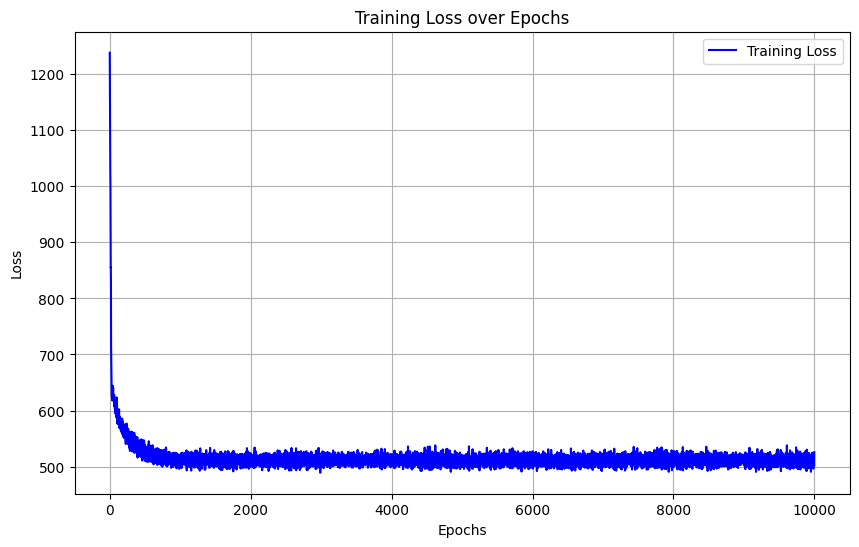

In [9]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.bitlinear.weight

Parameter containing:
tensor([[-1.7925e+01, -1.7919e+01, -1.7918e+01, -6.2251e+01, -1.7916e+01,
         -1.7916e+01, -1.7917e+01, -1.7921e+01, -1.7921e+01, -1.7919e+01,
         -1.7918e+01, -4.2988e+01, -1.7916e+01, -1.7919e+01, -6.9264e+01,
         -1.7916e+01, -1.7919e+01, -1.7918e+01, -1.7922e+01, -1.7918e+01],
        [ 9.9200e+01, -9.9046e+01, -9.9248e+01,  9.9226e+01, -9.5423e+01,
          9.8967e+01, -9.8388e+01, -9.8877e+01,  9.9062e+01,  9.7910e+01,
         -9.9103e+01, -9.8796e+01, -9.8792e+01,  9.8951e+01, -9.7427e+01,
          9.8804e+01, -9.8593e+01,  9.9049e+01, -1.7916e+01,  9.9113e+01],
        [-1.7916e+01, -1.7917e+01, -1.7922e+01, -1.7921e+01, -1.7916e+01,
         -1.7920e+01, -1.7924e+01, -1.7919e+01, -3.7513e+01, -1.7919e+01,
         -1.7920e+01, -1.7919e+01, -1.7920e+01, -1.7921e+01, -1.7918e+01,
         -1.7919e+01, -1.7920e+01, -1.7917e+01, -1.7918e+01, -1.7925e+01],
        [-1.7921e+01, -1.7918e+01, -1.7922e+01, -1.7918e+01, -1.7917e+01,
         -1.7

In [14]:
model.bitlinear.weight.dtype

torch.float32

In [13]:
model.bitlinear.binarize_weights_groupwise()

tensor([[-1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
         -1.,  1., -1., -1., -1., -1.],
        [ 1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
         -1.,  1., -1.,  1.,  1.,  1.],
        [ 1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
         -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,
         -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,
          1., -1., -1., -1.,  1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,
         -1., -1., -1.,  1., -1., -1.],
        [ 1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
         -1.,  1., -1.,  1., -1.,  1.],
        [ 1., -1.,  1., -1., -1.,  1., -1., -1.,

In [15]:
# 2. Saving the 1-bit quantized weights

# Extract the binarized weights from the model
binarized_weights = model.bitlinear.binarize_weights_groupwise()

# Define the path to save the binarized weights
binarized_weights_path = "./binarized_weights.pth"

# Save the binarized weights
torch.save(binarized_weights, binarized_weights_path)

binarized_weights_path


'./binarized_weights.pth'

In [16]:
# 1. Load the binarized weights
loaded_binarized_weights = torch.load(binarized_weights_path)

# 2. Set the model's weights to the loaded binarized weights
# (Note: Here we're directly setting the weights without binarizing again. This is specific to our current implementation.)
model.bitlinear.weight.data = loaded_binarized_weights

# 3. Perform inference
# For demonstration, let's use the same input data we used for training
with torch.no_grad():  # Ensure no gradients are computed for inference
    inference_output = model(inputs)

inference_output.shape

torch.Size([1000, 30])

In [18]:
model.bitlinear.weight.dtype

torch.float32